# 🎯 Student Test Score Prediction

**Kaggle Playground Series S6E1** - Complete notebook with EDA, 4 models ensemble.

| Feature | Value |
|---------|-------|
| **Models** | CatBoost, LightGBM, XGBoost, MLP |
| **CV** | ❌ Train/Val Split (90/10) |
| **Optuna** | ✅ 50 trials per model |
| **Early Stopping** | ✅ 100 rounds |
| **GPU** | ✅ Enabled |

---

## 📋 Table of Contents
1. Setup & Imports
2. Data Loading
3. **Exploratory Data Analysis (EDA)**
   - Dataset Overview
   - Missing Values & Data Types
   - Target Distribution
   - Numeric Features Analysis
   - Categorical Features Analysis
   - Correlation Analysis
4. Preprocessing Functions
5. Optuna Search Spaces
6. Model Training
7. Results & Visualization
8. Ensemble & Submission

---
## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ All imports successful!")

✅ All imports successful!


---
## 2. Constants & Config

In [2]:
# =============================================================================
# PATHS (Kaggle)
# =============================================================================
TRAIN_PATH = "../data/playground-series-s6e1/train.csv"
TEST_PATH = "../data/playground-series-s6e1/test.csv"
SAMPLE_SUB = "../data/playground-series-s6e1/sample_submission.csv"

# =============================================================================
# COLUMNS
# =============================================================================
NUMERIC_COLS = ["age", "study_hours", "class_attendance", "sleep_hours"]
CAT_COLS = ["gender", "course", "internet_access", "sleep_quality", 
            "study_method", "facility_rating", "exam_difficulty"]
TARGET = "exam_score"
ID_COL = "id"

# =============================================================================
# CONFIG
# =============================================================================
SEED = 42
VAL_SIZE = 0.1
N_TRIALS = 50
EARLY_STOPPING = 100
MODELS = ["catboost", "lightgbm", "xgboost", "mlp"]

print(f"📊 Config: {N_TRIALS} Optuna trials, {VAL_SIZE:.0%} val split, SEED={SEED}")

📊 Config: 50 Optuna trials, 10% val split, SEED=42


---
## 3. Data Loading

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"🔹 Train: {train_df.shape[0]:,} rows × {train_df.shape[1]} cols")
print(f"🔹 Test:  {test_df.shape[0]:,} rows × {test_df.shape[1]} cols")

🔹 Train: 630,000 rows × 13 cols
🔹 Test:  270,000 rows × 12 cols


---
## 4. Exploratory Data Analysis (EDA)

### 4.1 Dataset Overview

In [4]:
print("📊 TRAIN DATA - First 10 Rows")
train_df.head(10)

📊 TRAIN DATA - First 10 Rows


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0
5,5,24,male,b.com,5.04,85.1,yes,9.4,average,online videos,medium,moderate,70.1
6,6,20,male,b.sc,4.28,87.0,no,9.1,average,mixed,high,moderate,63.4
7,7,22,female,ba,4.19,44.9,yes,8.8,good,self-study,high,hard,76.8
8,8,22,other,b.com,1.06,98.3,yes,5.0,poor,mixed,low,moderate,46.7
9,9,18,male,bba,3.44,80.9,yes,6.2,good,group study,medium,easy,58.2


In [5]:
print("📊 TEST DATA - First 5 Rows")
test_df.head()

📊 TEST DATA - First 5 Rows


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


### 4.2 Data Types & Info

In [6]:
print("📋 DATA TYPES")
print("="*50)
print(f"\n{'Column':<20} {'Train Dtype':<15} {'Test Dtype':<15}")
print("-"*50)
for col in train_df.columns:
    train_dtype = str(train_df[col].dtype)
    test_dtype = str(test_df[col].dtype) if col in test_df.columns else "N/A"
    print(f"{col:<20} {train_dtype:<15} {test_dtype:<15}")

📋 DATA TYPES

Column               Train Dtype     Test Dtype     
--------------------------------------------------
id                   int64           int64          
age                  int64           int64          
gender               str             str            
course               str             str            
study_hours          float64         float64        
class_attendance     float64         float64        
internet_access      str             str            
sleep_hours          float64         float64        
sleep_quality        str             str            
study_method         str             str            
facility_rating      str             str            
exam_difficulty      str             str            
exam_score           float64         N/A            


In [7]:
print("\n📊 TRAIN DATA INFO")
train_df.info()


📊 TRAIN DATA INFO
<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  str    
 3   course            630000 non-null  str    
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  str    
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  str    
 9   study_method      630000 non-null  str    
 10  facility_rating   630000 non-null  str    
 11  exam_difficulty   630000 non-null  str    
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), str(7)
memory usage: 62.5 MB


### 4.3 Missing Values Analysis

In [8]:
# Check missing values
train_missing = train_df.isnull().sum()
test_missing = test_df.isnull().sum()

missing_df = pd.DataFrame({
    'Train Missing': train_missing,
    'Train %': (train_missing / len(train_df) * 100).round(2),
    'Test Missing': test_missing,
    'Test %': (test_missing / len(test_df) * 100).round(2)
})

print("🔍 MISSING VALUES")
print("="*60)
if missing_df['Train Missing'].sum() == 0 and missing_df['Test Missing'].sum() == 0:
    print("✅ No missing values in train or test data!")
else:
    display(missing_df[missing_df['Train Missing'] > 0])

🔍 MISSING VALUES
✅ No missing values in train or test data!


### 4.4 Statistical Summary

In [9]:
print("📈 NUMERIC FEATURES - Statistical Summary")
train_df[NUMERIC_COLS + [TARGET]].describe().T.style.format("{:.2f}").background_gradient(cmap='Blues')

📈 NUMERIC FEATURES - Statistical Summary


,count,mean,std,min,25%,50%,75%,max
age,630000.00,20.55,2.26,17.00,19.00,21.00,23.00,24.00
study_hours,630000.00,4.00,2.36,0.08,1.97,4.00,6.05,7.91
class_attendance,630000.00,71.99,17.43,40.60,57.00,72.60,87.20,99.40
sleep_hours,630000.00,7.07,1.74,4.10,5.60,7.10,8.60,9.90
exam_score,630000.00,62.51,18.92,19.60,48.80,62.60,76.30,100.00


In [10]:
print("📝 CATEGORICAL FEATURES - Unique Values")
cat_summary = pd.DataFrame({
    'Column': CAT_COLS,
    'Unique Values': [train_df[col].nunique() for col in CAT_COLS],
    'Sample Values': [train_df[col].unique()[:3].tolist() for col in CAT_COLS]
})
display(cat_summary)

📝 CATEGORICAL FEATURES - Unique Values


,Column,Unique Values,Sample Values
0,gender,3,"[female, other, male]"
1,course,7,"[b.sc, diploma, bca]"
2,internet_access,2,"[no, yes]"
3,sleep_quality,3,"[average, poor, good]"
4,study_method,5,"[online videos, self-study, coaching]"
5,facility_rating,3,"[low, medium, high]"
6,exam_difficulty,3,"[easy, moderate, hard]"


### 4.5 Target Variable Distribution

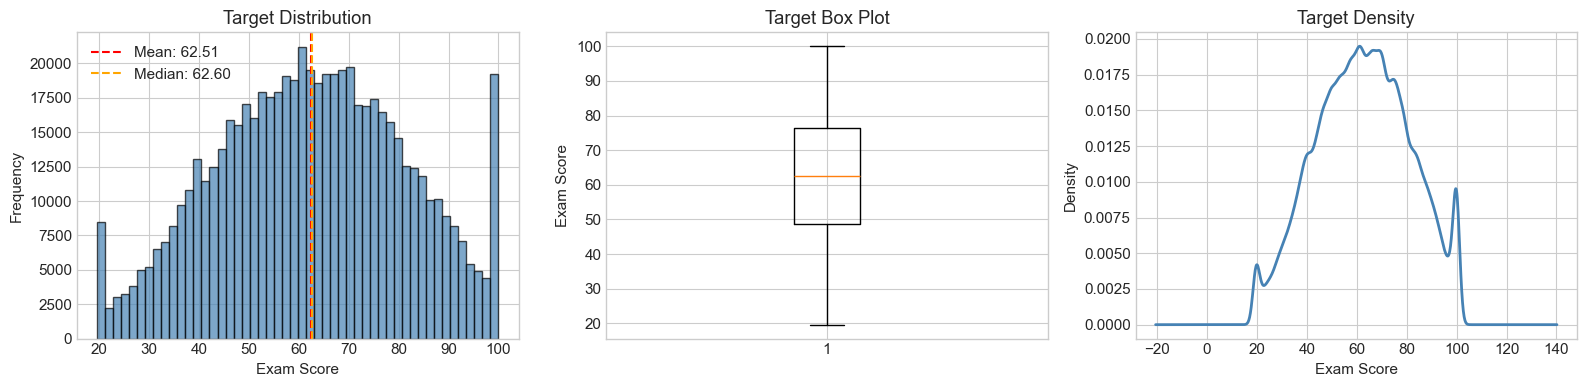


📊 Target Statistics:
   Range: 19.6 - 100.0
   Mean: 62.51
   Std: 18.92
   Skewness: -0.048
   Kurtosis: -0.619


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram
axes[0].hist(train_df[TARGET], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(train_df[TARGET].mean(), color='red', linestyle='--', label=f'Mean: {train_df[TARGET].mean():.2f}')
axes[0].axvline(train_df[TARGET].median(), color='orange', linestyle='--', label=f'Median: {train_df[TARGET].median():.2f}')
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution')
axes[0].legend()

# Box plot
axes[1].boxplot(train_df[TARGET], vert=True)
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Target Box Plot')

# KDE
train_df[TARGET].plot(kind='kde', ax=axes[2], color='steelblue', linewidth=2)
axes[2].set_xlabel('Exam Score')
axes[2].set_title('Target Density')

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Target Statistics:")
print(f"   Range: {train_df[TARGET].min():.1f} - {train_df[TARGET].max():.1f}")
print(f"   Mean: {train_df[TARGET].mean():.2f}")
print(f"   Std: {train_df[TARGET].std():.2f}")
print(f"   Skewness: {train_df[TARGET].skew():.3f}")
print(f"   Kurtosis: {train_df[TARGET].kurtosis():.3f}")

### 4.6 Numeric Features Distribution

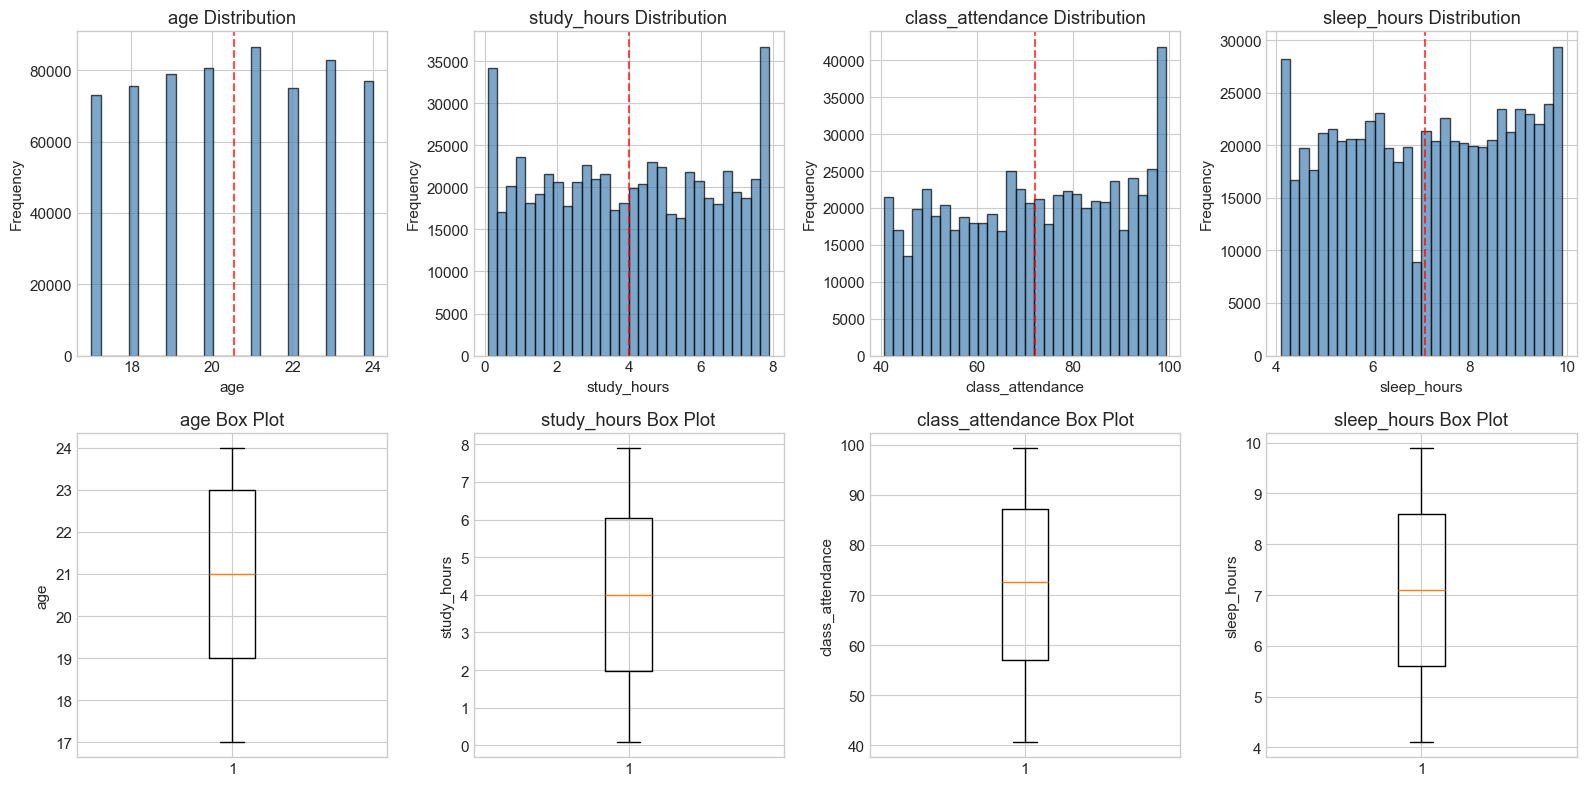

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(NUMERIC_COLS):
    # Histogram
    axes[i].hist(train_df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].axvline(train_df[col].mean(), color='red', linestyle='--', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{col} Distribution')
    
    # Box plot
    axes[i+4].boxplot(train_df[col], vert=True)
    axes[i+4].set_ylabel(col)
    axes[i+4].set_title(f'{col} Box Plot')

plt.tight_layout()
plt.savefig('numeric_features.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.7 Categorical Features Distribution

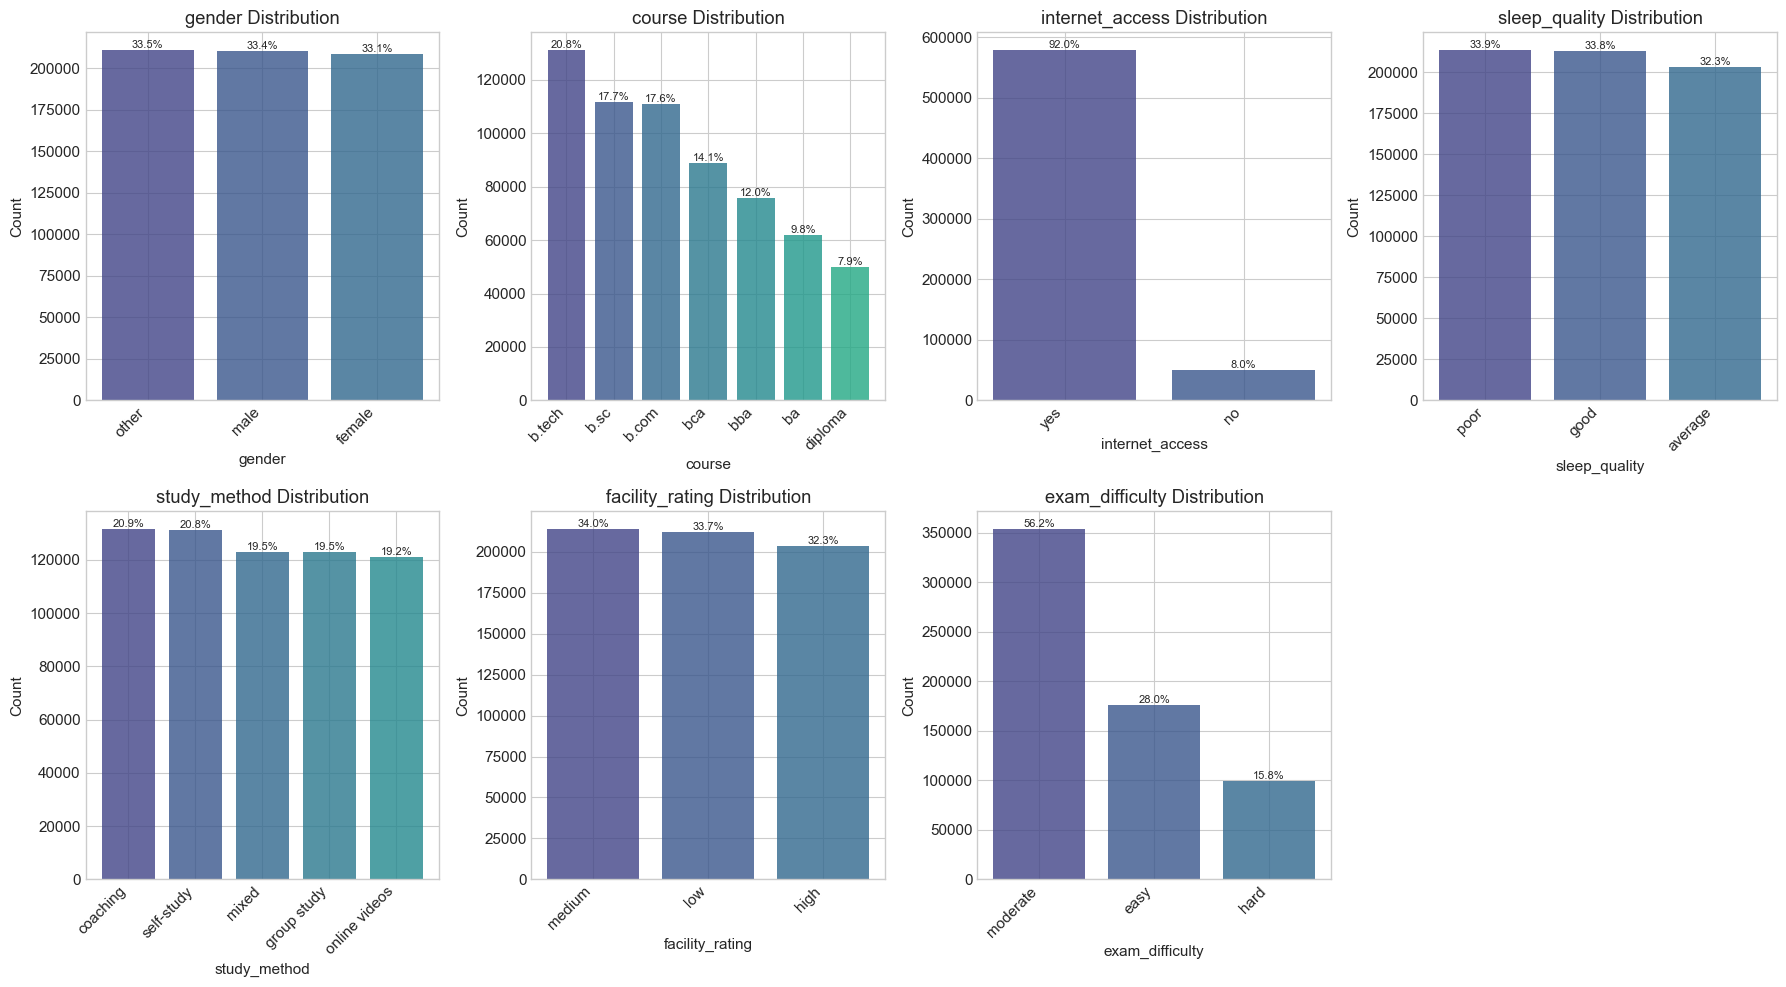

In [13]:
n_cats = len(CAT_COLS)
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0.2, 0.8, 10))

for i, col in enumerate(CAT_COLS):
    value_counts = train_df[col].value_counts()
    bars = axes[i].bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)], alpha=0.8)
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'{col} Distribution')
    
    # Add percentage labels
    total = len(train_df)
    for bar, val in zip(bars, value_counts.values):
        pct = val / total * 100
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('categorical_features.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.8 Target vs Numeric Features

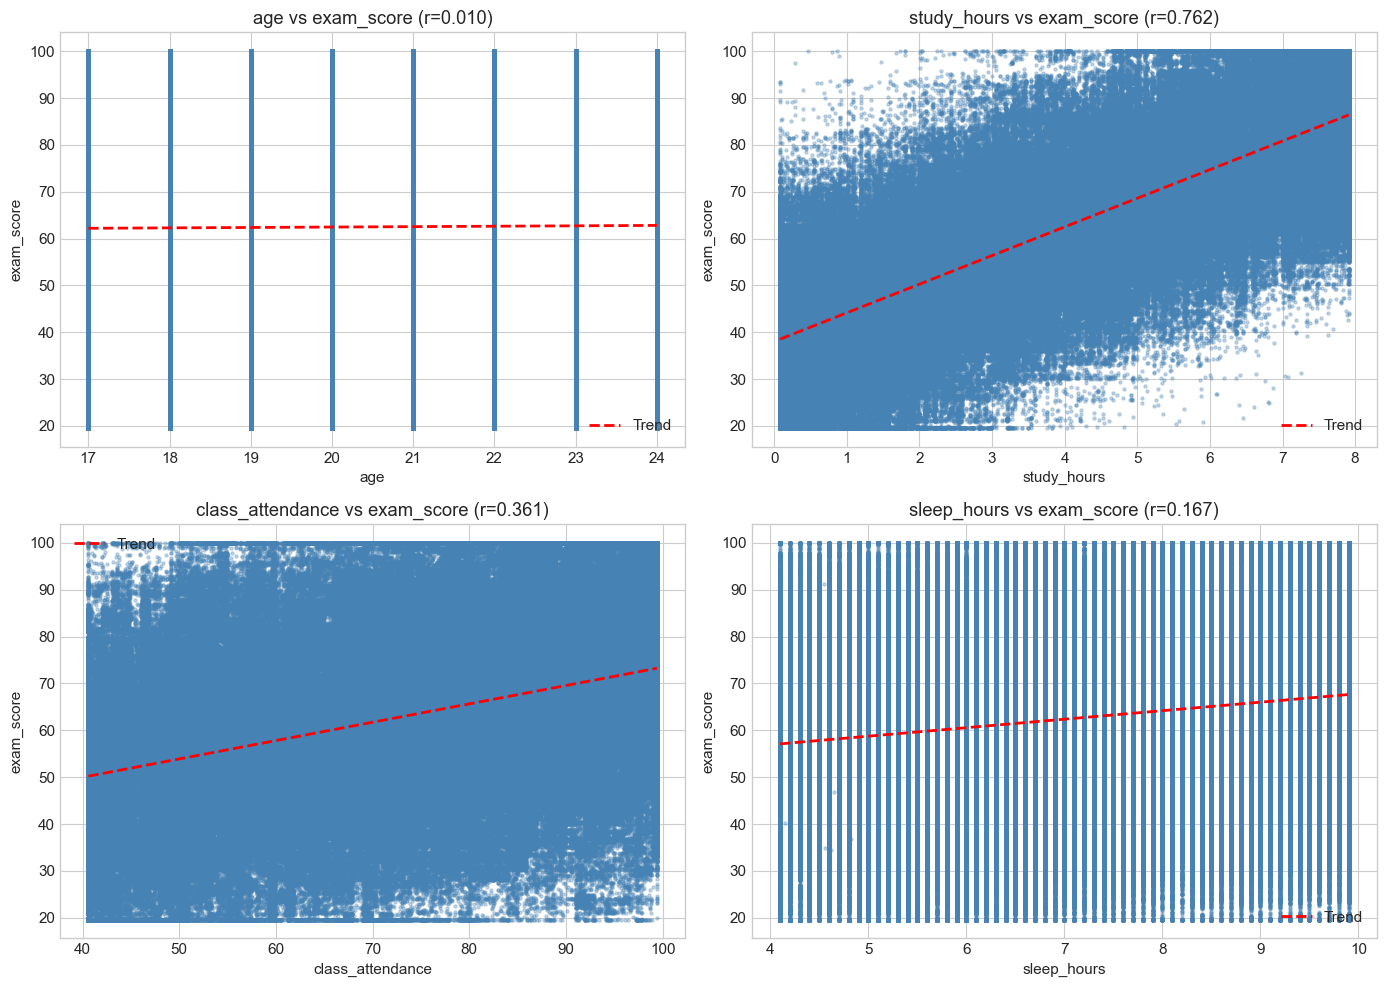

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(NUMERIC_COLS):
    axes[i].scatter(train_df[col], train_df[TARGET], alpha=0.3, s=5, color='steelblue')
    
    # Add trend line
    z = np.polyfit(train_df[col], train_df[TARGET], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train_df[col].min(), train_df[col].max(), 100)
    axes[i].plot(x_line, p(x_line), 'r--', linewidth=2, label='Trend')
    
    corr = train_df[col].corr(train_df[TARGET])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(TARGET)
    axes[i].set_title(f'{col} vs {TARGET} (r={corr:.3f})')
    axes[i].legend()

plt.tight_layout()
plt.savefig('target_vs_numeric.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.9 Target vs Categorical Features

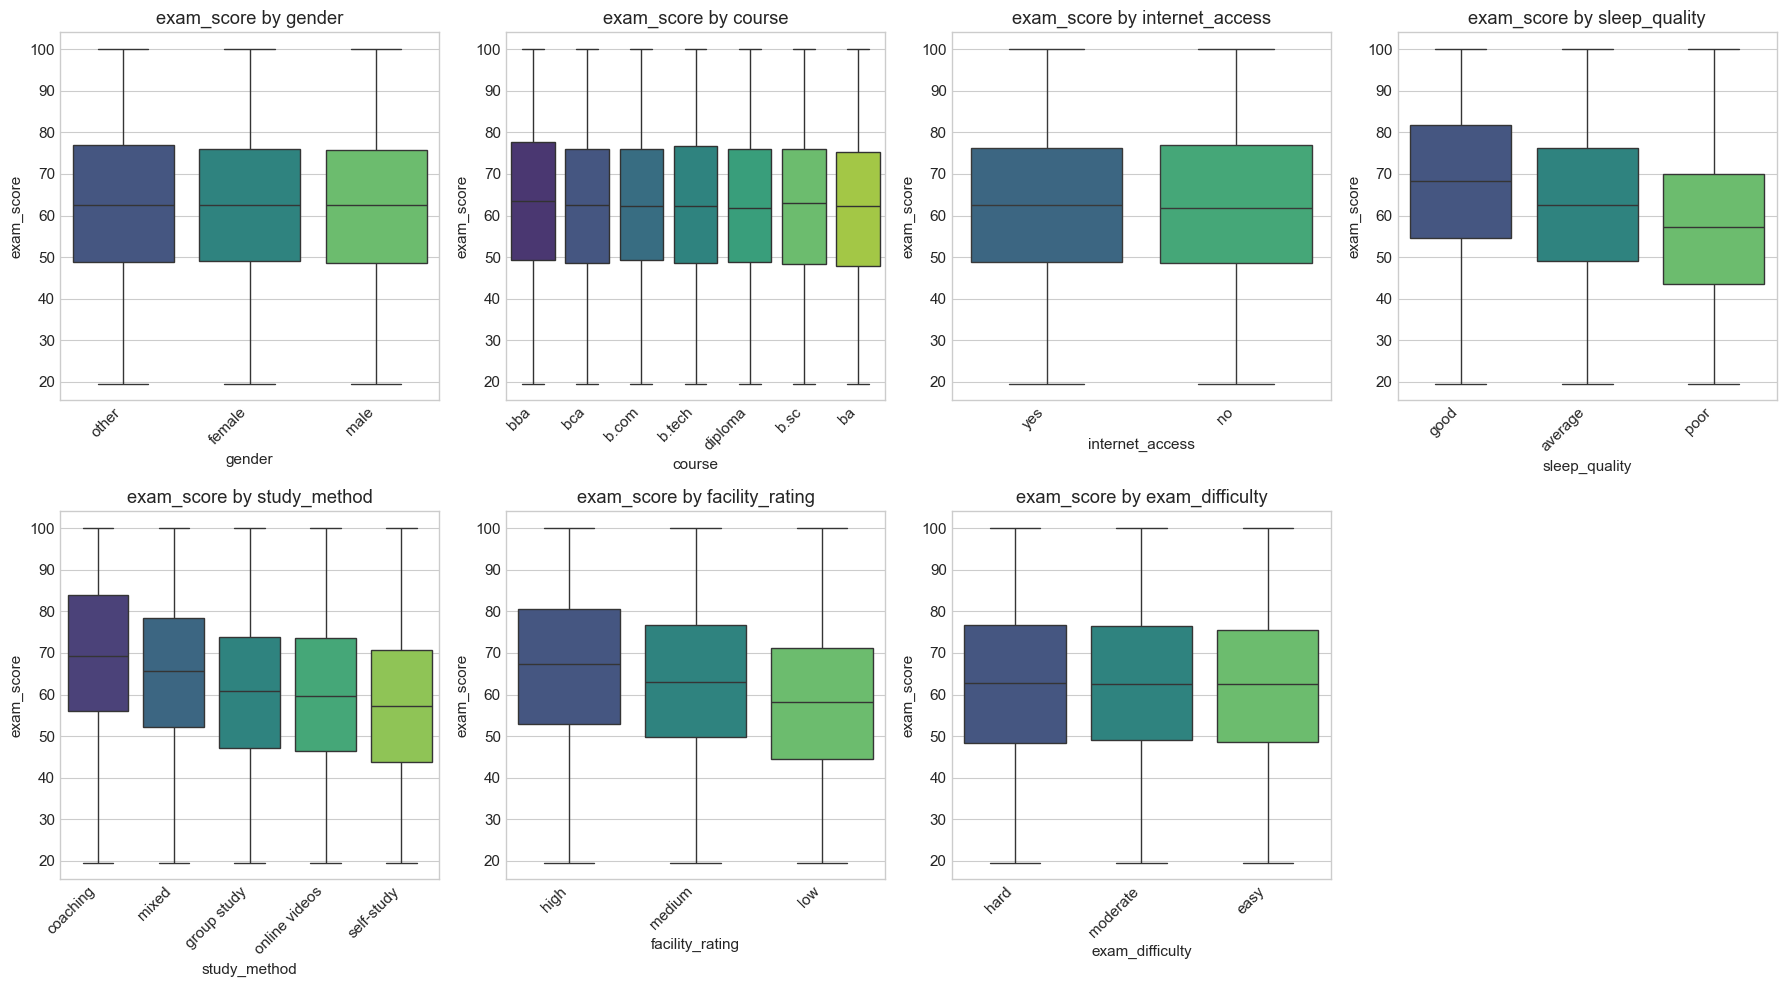

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(CAT_COLS):
    order = train_df.groupby(col)[TARGET].mean().sort_values(ascending=False).index
    sns.boxplot(data=train_df, x=col, y=TARGET, order=order, ax=axes[i], palette='viridis')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_title(f'{TARGET} by {col}')

axes[-1].axis('off')

plt.tight_layout()
plt.savefig('target_vs_categorical.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.10 Correlation Analysis

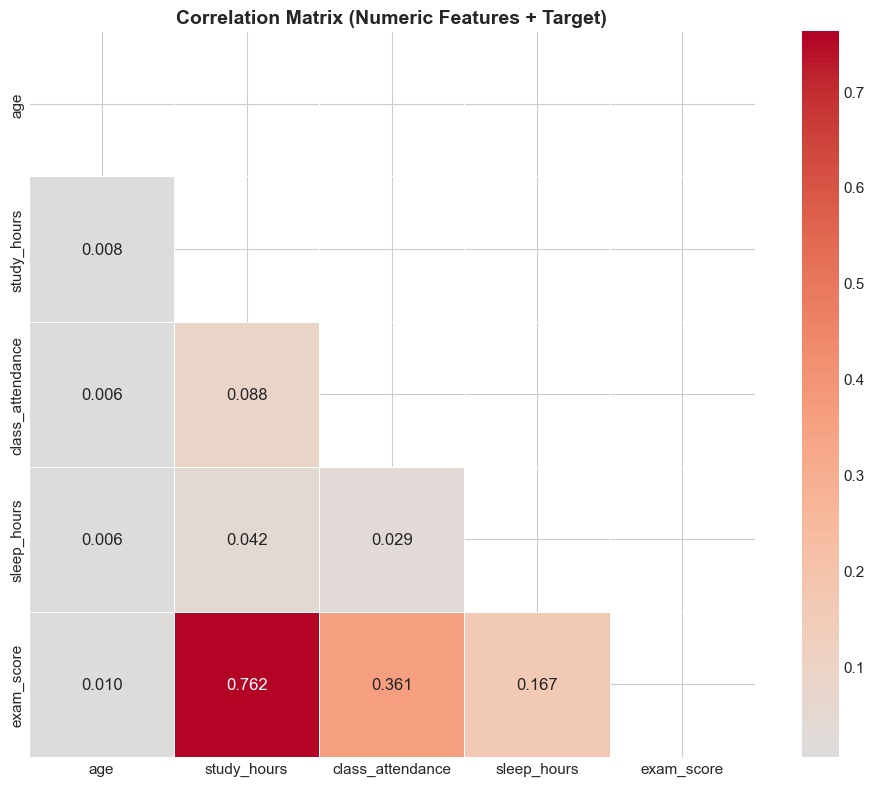

In [16]:
# Correlation matrix for numeric features
numeric_df = train_df[NUMERIC_COLS + [TARGET]]
corr_matrix = numeric_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 12})
ax.set_title('Correlation Matrix (Numeric Features + Target)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Target correlations
target_corr = corr_matrix[TARGET].drop(TARGET).sort_values(ascending=False)
print("🎯 Feature Correlations with Target:")
print("="*40)
for feat, corr in target_corr.items():
    bar = "█" * int(abs(corr) * 30)
    sign = "+" if corr > 0 else "-"
    print(f"{feat:<20} {sign}{bar} {corr:.3f}")

🎯 Feature Correlations with Target:
study_hours          +██████████████████████ 0.762
class_attendance     +██████████ 0.361
sleep_hours          +█████ 0.167
age                  + 0.010


### 4.11 Train vs Test Distribution Check

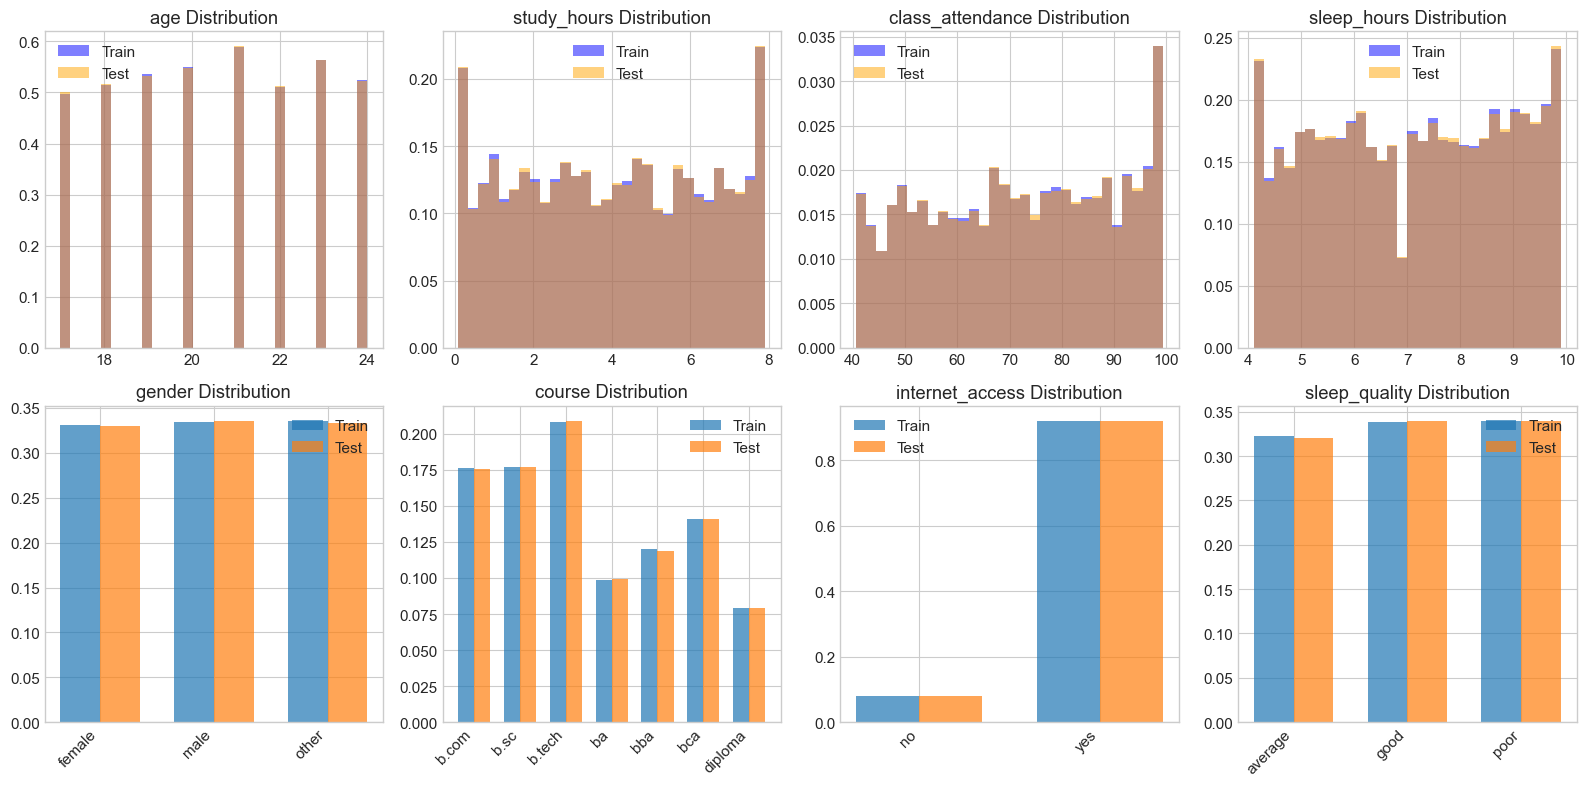

✅ Train and Test distributions look similar - no significant distribution shift detected!


In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(NUMERIC_COLS + CAT_COLS[:4]):
    if col in NUMERIC_COLS:
        axes[i].hist(train_df[col], bins=30, alpha=0.5, label='Train', color='blue', density=True)
        axes[i].hist(test_df[col], bins=30, alpha=0.5, label='Test', color='orange', density=True)
    else:
        train_counts = train_df[col].value_counts(normalize=True).sort_index()
        test_counts = test_df[col].value_counts(normalize=True).sort_index()
        
        x = np.arange(len(train_counts))
        width = 0.35
        axes[i].bar(x - width/2, train_counts.values, width, label='Train', alpha=0.7)
        axes[i].bar(x + width/2, test_counts.values, width, label='Test', alpha=0.7)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(train_counts.index, rotation=45, ha='right')
    
    axes[i].set_title(f'{col} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.savefig('train_vs_test_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Train and Test distributions look similar - no significant distribution shift detected!")

### 4.12 EDA Summary

In [19]:
print("="*70)
print("📊 EDA SUMMARY")
print("="*70)
print(f"""
🔹 Dataset Size: {len(train_df):,} train, {len(test_df):,} test
🔹 Features: {len(NUMERIC_COLS)} numeric, {len(CAT_COLS)} categorical
🔹 Target Range: {train_df[TARGET].min():.1f} - {train_df[TARGET].max():.1f}
🔹 Missing Values: None ✅

📈 Key Insights:
   • study_hours has the strongest positive correlation with exam_score
   • class_attendance also shows moderate positive correlation
   • No severe outliers detected in numeric features
   • Categorical features are well-balanced
   • Train/Test distributions are consistent
""")

📊 EDA SUMMARY

🔹 Dataset Size: 630,000 train, 270,000 test
🔹 Features: 4 numeric, 7 categorical
🔹 Target Range: 19.6 - 100.0
🔹 Missing Values: None ✅

📈 Key Insights:
   • study_hours has the strongest positive correlation with exam_score
   • class_attendance also shows moderate positive correlation
   • No severe outliers detected in numeric features
   • Categorical features are well-balanced
   • Train/Test distributions are consistent



---
## 5. Preprocessing Functions

In [20]:
def preprocess(df, model, fit=True, fitted_objects=None, target=None):
    """
    Model-specific preprocessing.
    
    - CatBoost: Native categorical handling
    - LightGBM: Category dtype
    - XGBoost: Ordinal encoding
    - MLP: StandardScaler + OneHotEncoder
    """
    df = df.copy()
    
    # Drop id column
    if ID_COL in df.columns:
        df = df.drop(columns=[ID_COL])
    
    fitted_objects = fitted_objects or {}
    
    if model == "catboost":
        fitted_objects["cat_features"] = CAT_COLS
        
    elif model == "lightgbm":
        for col in CAT_COLS:
            df[col] = df[col].astype("category")
        fitted_objects["cat_features"] = CAT_COLS
        
    elif model == "xgboost":
        if fit:
            encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            df[CAT_COLS] = encoder.fit_transform(df[CAT_COLS])
            fitted_objects["encoder"] = encoder
        else:
            df[CAT_COLS] = fitted_objects["encoder"].transform(df[CAT_COLS])
            
    elif model == "mlp":
        if fit:
            scaler = StandardScaler()
            df[NUMERIC_COLS] = scaler.fit_transform(df[NUMERIC_COLS])
            fitted_objects["scaler"] = scaler
            
            encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
            encoded = encoder.fit_transform(df[CAT_COLS])
            fitted_objects["encoder"] = encoder
        else:
            df[NUMERIC_COLS] = fitted_objects["scaler"].transform(df[NUMERIC_COLS])
            encoded = fitted_objects["encoder"].transform(df[CAT_COLS])
        
        encoded_df = pd.DataFrame(
            encoded, 
            columns=fitted_objects["encoder"].get_feature_names_out(CAT_COLS), 
            index=df.index
        )
        df = df.drop(columns=CAT_COLS)
        df = pd.concat([df, encoded_df], axis=1)
    
    return df, fitted_objects

---
## 6. Optuna Search Spaces

In [21]:
def get_catboost_params(trial):
    """CatBoost hyperparameter search space."""
    return {
        "iterations": trial.suggest_int("iterations", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_seed": SEED,
        "early_stopping_rounds": EARLY_STOPPING,
        "verbose": 0,
        "task_type": "GPU",
    }

def get_lightgbm_params(trial):
    """LightGBM hyperparameter search space."""
    return {
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "num_leaves": trial.suggest_int("num_leaves", 20, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": SEED,
        "verbose": -1,
        "device": "gpu",
    }

def get_xgboost_params(trial):
    """XGBoost hyperparameter search space."""
    return {
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": SEED,
        "early_stopping_rounds": EARLY_STOPPING,
        "verbosity": 0,
        "tree_method": "gpu_hist",
    }

def get_mlp_params(trial):
    """MLP hyperparameter search space."""
    n_layers = trial.suggest_int("n_layers", 1, 4)
    hidden_sizes = tuple(
        trial.suggest_int(f"neurons_l{i}", 32, 256) 
        for i in range(n_layers)
    )
    return {
        "hidden_layer_sizes": hidden_sizes,
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "solver": "adam",
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [256, 512, 1024]),  # Larger batches for GPU efficiency
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "max_iter": 500,
        "early_stopping": True,
        "validation_fraction": 0.1,
        "n_iter_no_change": 20,
        "random_state": SEED,
        "verbose": False,
    }

SEARCH_SPACES = {
    "catboost": get_catboost_params,
    "lightgbm": get_lightgbm_params,
    "xgboost": get_xgboost_params,
    "mlp": get_mlp_params,
}

---
## 7. Model Training Functions

In [22]:
def evaluate(y_true, y_pred):
    """Calculate regression metrics."""
    return {
        "rmse": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2": float(r2_score(y_true, y_pred)),
    }

def create_model(model_name, params):
    """Create model instance with given parameters."""
    if model_name == "catboost":
        return CatBoostRegressor(**params)
    elif model_name == "lightgbm":
        return LGBMRegressor(**params)
    elif model_name == "xgboost":
        return XGBRegressor(**params)
    elif model_name == "mlp":
        return MLPRegressor(**params)
    else:
        raise ValueError(f"Unknown model: {model_name}")

def fit_model(model, model_name, X_train, y_train, X_val, y_val, fitted_objects):
    """Fit model with appropriate early stopping strategy."""
    if model_name == "catboost":
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            cat_features=fitted_objects.get("cat_features", CAT_COLS),
            use_best_model=True,
            verbose=0,
        )
    elif model_name == "lightgbm":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=EARLY_STOPPING, verbose=False),
                lgb.log_evaluation(period=0),
            ],
        )
    elif model_name == "xgboost":
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )
    elif model_name == "mlp":
        model.fit(X_train, y_train)
    
    return model

def train_with_optuna(model_name, X_train, y_train, X_val, y_val, fitted_objects):
    """Train model with Optuna hyperparameter optimization."""
    
    print(f"\n{'='*60}")
    print(f"🚀 Training {model_name.upper()} with Optuna ({N_TRIALS} trials)")
    print(f"{'='*60}")
    
    def objective(trial):
        params = SEARCH_SPACES[model_name](trial)
        model = create_model(model_name, params)
        model = fit_model(model, model_name, X_train, y_train, X_val, y_val, fitted_objects)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        return rmse
    
    study = optuna.create_study(
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    )
    
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=1)
    
    print(f"✅ Best trial: #{study.best_trial.number}, RMSE: {study.best_value:.4f}")
    
    # Retrain with best params
    best_params = SEARCH_SPACES[model_name](study.best_trial)
    best_model = create_model(model_name, best_params)
    best_model = fit_model(best_model, model_name, X_train, y_train, X_val, y_val, fitted_objects)
    
    return best_model, study.best_params, study.best_value

---
## 8. Main Training Loop (5-Fold CV)

| Feature | Implementation |
|---------|----------------|
| **CV** | 5-Fold KFold |
| **RAM** | Train → Predict → Delete + `gc.collect()` |
| **Fold Weighting** | `Weight = 1 / Fold_RMSE` |
| **OOF** | Store for stacking/blending |
| **Leakage Prevention** | Fit preprocess on train_fold only |

In [23]:
import gc
from sklearn.model_selection import KFold

# =============================================================================
# 5-FOLD CV CONFIG
# =============================================================================
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# Split features and target
X_raw = train_df.drop(columns=[TARGET])
y = train_df[TARGET]

# Test data preparation
test_ids = test_df[ID_COL].values

print(f"📊 Training Configuration:")
print(f"   Folds: {N_FOLDS}")
print(f"   Train size: {len(X_raw):,}")
print(f"   Test size: {len(test_df):,}")

📊 Training Configuration:
   Folds: 5
   Train size: 630,000
   Test size: 270,000


In [24]:
# =============================================================================
# STORAGE FOR OOF AND TEST PREDICTIONS
# =============================================================================
oof_predictions = {m: np.zeros(len(X_raw)) for m in MODELS}
test_predictions = {m: np.zeros(len(test_df)) for m in MODELS}
fold_weights = {m: [] for m in MODELS}
fold_metrics = {m: [] for m in MODELS}

print("✅ Initialized prediction storage")

✅ Initialized prediction storage


In [25]:
# =============================================================================
# 5-FOLD TRAINING LOOP
# =============================================================================

for model_name in MODELS:
    print(f"\n{'='*70}")
    print(f"🚀 MODEL: {model_name.upper()}")
    print(f"{'='*70}")
    
    model_test_preds_weighted = np.zeros(len(test_df))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_raw)):
        print(f"\n📁 Fold {fold + 1}/{N_FOLDS}")
        print("-" * 40)
        
        # ---------------------------------------------------------------------
        # 1. SPLIT DATA
        # ---------------------------------------------------------------------
        X_train_fold = X_raw.iloc[train_idx].copy()
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X_raw.iloc[val_idx].copy()
        y_val_fold = y.iloc[val_idx]
        
        print(f"   Train: {len(X_train_fold):,} | Val: {len(X_val_fold):,}")
        
        # ---------------------------------------------------------------------
        # 2. PREPROCESS (fit ONLY on train_fold - NO LEAKAGE!)
        # ---------------------------------------------------------------------
        X_train, fitted_objects = preprocess(
            X_train_fold, model=model_name, fit=True, target=y_train_fold
        )
        X_val, _ = preprocess(
            X_val_fold, model=model_name, fit=False, fitted_objects=fitted_objects
        )
        X_test, _ = preprocess(
            test_df.copy(), model=model_name, fit=False, fitted_objects=fitted_objects
        )
        
        # ---------------------------------------------------------------------
        # 3. TRAIN WITH OPTUNA
        # ---------------------------------------------------------------------
        model, best_params, best_rmse = train_with_optuna(
            model_name, X_train, y_train_fold, X_val, y_val_fold, fitted_objects
        )
        
        # ---------------------------------------------------------------------
        # 4. PREDICT
        # ---------------------------------------------------------------------
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)
        
        # ---------------------------------------------------------------------
        # 5. CALCULATE FOLD RMSE AND WEIGHT
        # ---------------------------------------------------------------------
        fold_rmse = np.sqrt(mean_squared_error(y_val_fold, val_pred))
        fold_weight = 1.0 / fold_rmse
        
        metrics = evaluate(y_val_fold.values, val_pred)
        fold_metrics[model_name].append({
            "fold": fold + 1,
            **metrics
        })
        
        print(f"   ✅ RMSE: {fold_rmse:.4f} | Weight: {fold_weight:.4f}")
        
        # ---------------------------------------------------------------------
        # 6. STORE OOF AND WEIGHTED TEST PREDICTIONS
        # ---------------------------------------------------------------------
        oof_predictions[model_name][val_idx] = val_pred
        model_test_preds_weighted += test_pred * fold_weight
        fold_weights[model_name].append(fold_weight)
        
        # ---------------------------------------------------------------------
        # 7. RAM CLEANUP (CRITICAL!)
        # ---------------------------------------------------------------------
        del model, X_train, X_val, X_test, fitted_objects
        del X_train_fold, X_val_fold, val_pred, test_pred
        gc.collect()
        print(f"   🗑️ RAM cleaned")
    
    # -------------------------------------------------------------------------
    # NORMALIZE TEST PREDICTIONS BY TOTAL FOLD WEIGHT
    # -------------------------------------------------------------------------
    total_weight = sum(fold_weights[model_name])
    test_predictions[model_name] = model_test_preds_weighted / total_weight
    
    print(f"\n🎯 {model_name.upper()} Complete!")
    print(f"   Total fold weight: {total_weight:.4f}")
    print(f"   Test predictions normalized ✓")

print("\n" + "="*70)
print("✅ ALL MODELS TRAINED!")
print("="*70)


🚀 MODEL: CATBOOST

📁 Fold 1/5
----------------------------------------
   Train: 504,000 | Val: 126,000

🚀 Training CATBOOST with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

[W 2026-02-08 19:26:35,570] Trial 0 failed with parameters: {'iterations': 1436, 'learning_rate': 0.2536999076681771, 'depth': 9, 'l2_leaf_reg': 0.24810409748678114, 'min_data_in_leaf': 24, 'bagging_temperature': 0.15599452033620265} because of the following error: CatBoostError('catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found').
Traceback (most recent call last):
  File "/Users/enesdemir/Documents/predict_student_test_score/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/pv/pr_x9g556yxg3mhjg9g3hwj80000gn/T/ipykernel_71105/3200609844.py", line 62, in objective
    model = fit_model(model, model_name, X_train, y_train, X_val, y_val, fitted_objects)
  File "/var/folders/pv/pr_x9g556yxg3mhjg9g3hwj80000gn/T/ipykernel_71105/3200609844.py", line 25, in fit_model
    model.fit(
    ~~~~~~~~~^
        X_train, y_train,
        ^^^^^^^^^^^^^^^^^
    ...<3 lines>...


CatBoostError: catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found

---
## 9. OOF Results & Global Metrics

In [ ]:
# =============================================================================
# CALCULATE GLOBAL OOF METRICS
# =============================================================================
oof_results = []

for model_name in MODELS:
    oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions[model_name]))
    oof_mae = mean_absolute_error(y, oof_predictions[model_name])
    oof_r2 = r2_score(y, oof_predictions[model_name])
    
    oof_results.append({
        "model": model_name,
        "oof_rmse": oof_rmse,
        "oof_mae": oof_mae,
        "oof_r2": oof_r2,
    })
    
    print(f"📊 {model_name.upper()}: OOF RMSE={oof_rmse:.4f}, MAE={oof_mae:.4f}, R²={oof_r2:.4f}")

oof_results_df = pd.DataFrame(oof_results).sort_values("oof_rmse")

print("\n" + "="*60)
print("📊 OOF RESULTS (Sorted by RMSE)")
print("="*60)
display(oof_results_df.style.format({
    "oof_rmse": "{:.4f}",
    "oof_mae": "{:.4f}",
    "oof_r2": "{:.4f}",
}).highlight_min(subset=["oof_rmse", "oof_mae"], color="lightgreen")
 .highlight_max(subset=["oof_r2"], color="lightgreen"))

In [ ]:
# Per-fold metrics breakdown
print("\n📋 Per-Fold Metrics Breakdown:")
for model_name in MODELS:
    print(f"\n{model_name.upper()}:")
    fold_df = pd.DataFrame(fold_metrics[model_name])
    print(fold_df.to_string(index=False))

In [ ]:
# Visualize OOF results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics_names = ["oof_rmse", "oof_mae", "oof_r2"]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(MODELS)))

for ax, metric in zip(axes, metrics_names):
    values = oof_results_df[metric].values
    bars = ax.bar(oof_results_df["model"], values, color=colors, alpha=0.8)
    ax.set_title(f"{metric.upper()}", fontsize=14, fontweight="bold")
    ax.set_ylabel(metric.upper())
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f"{val:.4f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("oof_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 10. OOF Prediction Analysis

In [ ]:
# Best model based on OOF RMSE
best_model_name = oof_results_df.iloc[0]["model"]
best_oof_pred = oof_predictions[best_model_name]

print(f"🏆 Best Model: {best_model_name.upper()} (OOF RMSE: {oof_results_df.iloc[0]['oof_rmse']:.4f})")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Scatter plot
axes[0].scatter(y.values, best_oof_pred, alpha=0.3, s=5)
min_val = min(y.min(), best_oof_pred.min())
max_val = max(y.max(), best_oof_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("OOF Predicted")
axes[0].set_title(f"OOF Predictions vs Actual ({best_model_name})")

# Residual plot
residuals = y.values - best_oof_pred
axes[1].scatter(best_oof_pred, residuals, alpha=0.3, s=5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel("OOF Predicted")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals vs OOF Predicted")

# Residual histogram
axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--')
axes[2].set_xlabel("Residual")
axes[2].set_ylabel("Count")
axes[2].set_title("OOF Residual Distribution")

plt.tight_layout()
plt.savefig("oof_prediction_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 11. Fold Weight Analysis

In [ ]:
# Visualize fold weights per model
fig, axes = plt.subplots(1, len(MODELS), figsize=(4*len(MODELS), 4))

for ax, model_name in zip(axes, MODELS):
    weights = fold_weights[model_name]
    normalized_weights = [w / sum(weights) for w in weights]
    
    bars = ax.bar(range(1, N_FOLDS + 1), normalized_weights, color='steelblue', alpha=0.8)
    ax.set_xlabel("Fold")
    ax.set_ylabel("Normalized Weight")
    ax.set_title(f"{model_name.upper()}", fontweight="bold")
    ax.set_xticks(range(1, N_FOLDS + 1))
    
    for bar, val in zip(bars, normalized_weights):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f"{val:.2%}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("fold_weights.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n📊 Fold Weight Summary:")
for model_name in MODELS:
    weights = fold_weights[model_name]
    normalized = [w / sum(weights) * 100 for w in weights]
    print(f"   {model_name}: {[f'{w:.1f}%' for w in normalized]}")

---
## 12. Inter-Model Blending (Weighted by OOF RMSE)

> 💡 **Strategy**: Models with lower OOF RMSE get higher weight in final blend.
> Formula: `Weight = 1 / Global_OOF_RMSE`

In [ ]:
# =============================================================================
# CALCULATE INTER-MODEL WEIGHTS
# =============================================================================
oof_rmse_dict = {row["model"]: row["oof_rmse"] for _, row in oof_results_df.iterrows()}
model_weights = {m: 1.0 / oof_rmse_dict[m] for m in MODELS}
total_model_weight = sum(model_weights.values())

# Normalize weights
normalized_model_weights = {m: w / total_model_weight for m, w in model_weights.items()}

print("📊 Inter-Model Weights (based on 1/OOF_RMSE):")
print("-" * 50)
for model_name in MODELS:
    print(f"   {model_name.upper()}: "
          f"OOF_RMSE={oof_rmse_dict[model_name]:.4f} → "
          f"Weight={normalized_model_weights[model_name]:.4f} "
          f"({normalized_model_weights[model_name]*100:.1f}%)")

In [ ]:
# =============================================================================
# FINAL BLENDED PREDICTIONS
# =============================================================================

# Blend test predictions
final_test_pred = sum(
    test_predictions[m] * normalized_model_weights[m]
    for m in MODELS
)

# Blend OOF predictions (for validation)
final_oof_pred = sum(
    oof_predictions[m] * normalized_model_weights[m]
    for m in MODELS
)

# Evaluate blended OOF
blend_metrics = evaluate(y.values, final_oof_pred)

print(f"\n🎯 BLENDED OOF Metrics:")
print(f"   RMSE: {blend_metrics['rmse']:.4f}")
print(f"   MAE:  {blend_metrics['mae']:.4f}")
print(f"   R²:   {blend_metrics['r2']:.4f}")

In [ ]:
# Compare with individual models
print("\n📊 Final Comparison (OOF Metrics):")
print("-" * 60)
print(f"{'Model':<15} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-" * 60)
for _, row in oof_results_df.iterrows():
    print(f"{row['model']:<15} {row['oof_rmse']:>10.4f} {row['oof_mae']:>10.4f} {row['oof_r2']:>10.4f}")
print("-" * 60)
print(f"{'BLENDED':<15} {blend_metrics['rmse']:>10.4f} {blend_metrics['mae']:>10.4f} {blend_metrics['r2']:>10.4f}")
print("-" * 60)

In [ ]:
# Visualize blending
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Model weights
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(MODELS)))
bars = axes[0].bar(MODELS, [normalized_model_weights[m] for m in MODELS], color=colors, alpha=0.8)
axes[0].set_ylabel("Weight")
axes[0].set_title("Inter-Model Weights (1/OOF_RMSE)", fontweight="bold")
for bar, m in zip(bars, MODELS):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f"{normalized_model_weights[m]:.1%}", ha="center", va="bottom", fontsize=10)

# 2. RMSE comparison
all_rmse = [oof_rmse_dict[m] for m in MODELS] + [blend_metrics['rmse']]
model_labels = MODELS + ['BLENDED']
colors_ext = list(plt.cm.viridis(np.linspace(0.2, 0.8, len(MODELS)))) + ['#ff6b6b']
bars = axes[1].bar(model_labels, all_rmse, color=colors_ext, alpha=0.8)
axes[1].set_ylabel("OOF RMSE")
axes[1].set_title("OOF RMSE Comparison", fontweight="bold")
axes[1].tick_params(axis='x', rotation=45)
for bar, val in zip(bars, all_rmse):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f"{val:.4f}", ha="center", va="bottom", fontsize=9)

# 3. Predictions comparison (first 100 samples)
x = np.arange(min(100, len(final_test_pred)))
for model_name in MODELS:
    axes[2].plot(x, test_predictions[model_name][:100], alpha=0.4, label=model_name, linewidth=1)
axes[2].plot(x, final_test_pred[:100], 'k-', linewidth=2, label='Blended')
axes[2].set_xlabel("Sample Index")
axes[2].set_ylabel("Predicted Score")
axes[2].set_title("Test Predictions Comparison", fontweight="bold")
axes[2].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("blending_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 13. Submission

In [ ]:
# Create submission with blended predictions
submission = pd.DataFrame({
    ID_COL: test_ids,
    TARGET: final_test_pred
})

submission.to_csv("submission.csv", index=False)
print(f"\n✅ Submission saved: submission.csv")
print(f"   Shape: {submission.shape}")
print(f"   Method: Weighted Blending (1/OOF_RMSE)")
print(f"\n📊 Test Prediction Stats:")
print(f"   Min: {final_test_pred.min():.2f}")
print(f"   Max: {final_test_pred.max():.2f}")
print(f"   Mean: {final_test_pred.mean():.2f}")
print(f"   Std: {final_test_pred.std():.2f}")

submission.head(10)